In [1]:
# Import Modules
import numpy as np
import pandas as pd
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math
import time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import datetime
from operator import itemgetter
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import statsmodels.api as sm 

from tqdm.notebook import tqdm

<ipython-input-1-eba7a4d58f64>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
for dirname, _, filenames in os.walk('/Users/josephyang/hkbu/FIN7850高频交易和算法/group project'):
    for filename in filenames:
        print(os.path.join(dirname,filename))
#read the file path


/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/.DS_Store
/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/600029.SS.csv
/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/sample/BitcoinLSTM.ipynb
/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/sample/.DS_Store
/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/sample/SentimentTrading.ipynb
/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/sample/DecisionTree.ipynb
/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/sample/DataSource.ipynb
/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/sample/BitcoinSMA.ipynb
/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/sample/HKStocksCorrelation.ipynb


In [3]:
data = pd.read_csv('/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/600029.SS.csv')
print(data.shape)
#read the csv file

(2430, 7)


In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-02-23,8.69,8.70,8.45,8.63,7.618300,52687449
1,2011-02-24,8.54,8.82,8.40,8.77,7.741889,45998923
2,2011-02-25,8.72,8.78,8.50,8.68,7.662439,34295358
3,2011-02-28,8.68,8.82,8.53,8.77,7.741889,51694946
4,2011-03-01,8.77,8.99,8.72,8.88,7.838994,59260810


In [5]:
techindi1 = copy.deepcopy(data)

In [6]:
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)

In [7]:
# Momentum_1D = P(t) - P(t-1)

techindi1['Momentum_1D'] = (techindi1['Close']-techindi1['Close'].shift(1)).fillna(0)
techindi1['RSI_14D'] = techindi1['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
techindi1.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D
2425,2021-02-09,6.18,6.21,6.11,6.20,6.20,50304320,0.01,65.753425
2426,2021-02-10,6.18,6.20,6.10,6.16,6.16,35436376,-0.04,66.666667
2427,2021-02-18,6.25,6.42,6.15,6.36,6.36,83791920,0.20,69.047619
2428,2021-02-19,6.29,6.51,6.28,6.35,6.35,70460839,-0.01,70.731707
2429,2021-02-22,6.33,6.40,6.21,6.31,6.31,60365317,-0.04,72.222222


In [8]:
#Calculation of Volume (Plain)
techindi1['Volume_plain'] = techindi1['Volume'].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D,Volume_plain
2425,2021-02-09,6.18,6.21,6.11,6.20,6.20,50304320,0.01,65.753425,50304320
2426,2021-02-10,6.18,6.20,6.10,6.16,6.16,35436376,-0.04,66.666667,35436376
2427,2021-02-18,6.25,6.42,6.15,6.36,6.36,83791920,0.20,69.047619,83791920
2428,2021-02-19,6.29,6.51,6.28,6.35,6.35,70460839,-0.01,70.731707,70460839
2429,2021-02-22,6.33,6.40,6.21,6.31,6.31,60365317,-0.04,72.222222,60365317


In [9]:
#Calculation of Bollinger Bands
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [10]:
techindi1['BB_Middle_Band'], techindi1['BB_Upper_Band'], techindi1['BB_Lower_Band'] = bbands(techindi1['Close'], length=20, numsd=1)
techindi1['BB_Middle_Band'] = techindi1['BB_Middle_Band'].fillna(0)
techindi1['BB_Upper_Band'] = techindi1['BB_Upper_Band'].fillna(0)
techindi1['BB_Lower_Band'] = techindi1['BB_Lower_Band'].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band
2425,2021-02-09,6.18,6.21,6.11,6.20,6.20,50304320,0.01,65.753425,50304320,5.775,5.947,5.604
2426,2021-02-10,6.18,6.20,6.10,6.16,6.16,35436376,-0.04,66.666667,35436376,5.795,5.987,5.604
2427,2021-02-18,6.25,6.42,6.15,6.36,6.36,83791920,0.20,69.047619,83791920,5.827,6.056,5.599
2428,2021-02-19,6.29,6.51,6.28,6.35,6.35,70460839,-0.01,70.731707,70460839,5.861,6.114,5.608
2429,2021-02-22,6.33,6.40,6.21,6.31,6.31,60365317,-0.04,72.222222,60365317,5.890,6.160,5.621


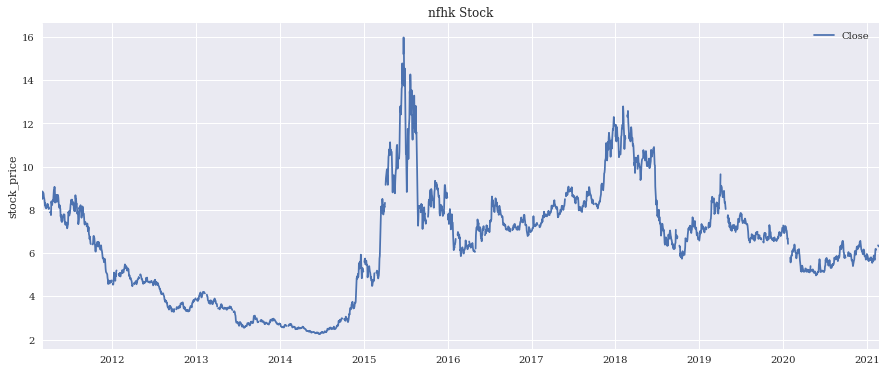

In [11]:
dates = pd.date_range('2011-03-01','2021-2-22',freq='B')
df1=pd.DataFrame(index=dates)
df_nfhk=pd.read_csv('/Users/josephyang/hkbu/FIN7850高频交易和算法/group project/600029.SS.csv', parse_dates=True, index_col=0)
df_nfhk=df1.join(df_nfhk)
df_nfhk[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("nfhk Stock")
plt.show()

In [12]:
df_nfhk=df_nfhk[['Close']]
df_nfhk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2605 entries, 2011-03-01 to 2021-02-22
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2426 non-null   float64
dtypes: float64(1)
memory usage: 120.7 KB


In [13]:
df_nfhk=df_nfhk.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_nfhk['Close'] = scaler.fit_transform(df_nfhk['Close'].values.reshape(-1,1))

In [14]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_nfhk, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2036, 59, 1)
y_train.shape =  (2036, 1)
x_test.shape =  (509, 59, 1)
y_test.shape =  (509, 1)


In [15]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [16]:
y_train.size(),x_train.size()

(torch.Size([2036, 1]), torch.Size([2036, 59, 1]))

In [17]:
n_steps = look_back-1
batch_size = 32
num_epochs = 100 #n_iters / (len(train_X) / batch_size)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

##Build the structure of LSTM model

In [18]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

# Here define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [19]:
# Train model

hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.06208287179470062
Epoch  20 MSE:  0.009634037502110004
Epoch  30 MSE:  0.005101184360682964
Epoch  40 MSE:  0.004168833140283823
Epoch  50 MSE:  0.0031364422757178545
Epoch  60 MSE:  0.002849026583135128
Epoch  70 MSE:  0.0024726365227252245
Epoch  80 MSE:  0.002214485313743353
Epoch  90 MSE:  0.002072970848530531


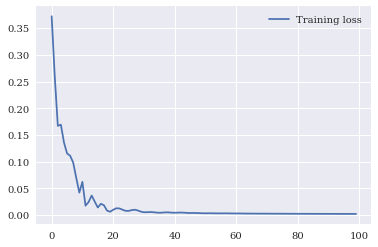

In [20]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [21]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.30 RMSE
Test Score: 0.19 RMSE


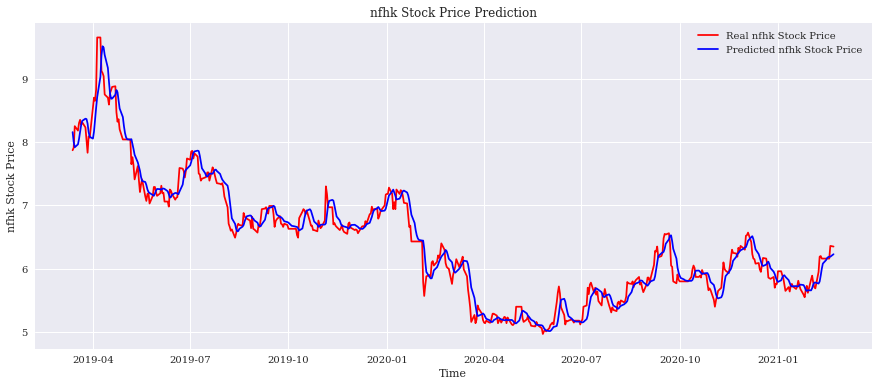

In [22]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_nfhk[len(df_nfhk)-len(y_test):].index, y_test, color = 'red', label = 'Real nfhk Stock Price')
axes.plot(df_nfhk[len(df_nfhk)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted nfhk Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('nfhk Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('nfhk Stock Price')
plt.legend()
plt.savefig('nfhk_pred.png')
plt.show()

In [23]:
#use 

In [24]:
techindi1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band
2425,2021-02-09,6.18,6.21,6.11,6.20,6.20,50304320,0.01,65.753425,50304320,5.775,5.947,5.604
2426,2021-02-10,6.18,6.20,6.10,6.16,6.16,35436376,-0.04,66.666667,35436376,5.795,5.987,5.604
2427,2021-02-18,6.25,6.42,6.15,6.36,6.36,83791920,0.20,69.047619,83791920,5.827,6.056,5.599
2428,2021-02-19,6.29,6.51,6.28,6.35,6.35,70460839,-0.01,70.731707,70460839,5.861,6.114,5.608
2429,2021-02-22,6.33,6.40,6.21,6.31,6.31,60365317,-0.04,72.222222,60365317,5.890,6.160,5.621


In [25]:
normalized_df1 = copy.deepcopy(techindi1)

In [26]:
#normalized_df1 ['Date'] = pd.to_datetime(normalized_df1 ['Date']) 
#normalized_df1  = normalized_df1.set_index('Date')

In [27]:
#def normalized_df(df):
#    normalized_df=(df-df.mean())/df.std()
#    return normalized_df

In [28]:
#normalized_df1.columns

In [29]:
#mean = normalized_df1.mean(axis = 0)
#normalized_df1 -= mean
#std = normalized_df1.std(axis=0)
#normalized_df1 /= std

In [30]:
normalized_df1 = normalized_df1.fillna(0) 
normalized_df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band
0,2011-02-23,8.69,8.70,8.45,8.63,7.618300,52687449,0.00,0.0,52687449,0.0,0.0,0.0
1,2011-02-24,8.54,8.82,8.40,8.77,7.741889,45998923,0.14,0.0,45998923,0.0,0.0,0.0
2,2011-02-25,8.72,8.78,8.50,8.68,7.662439,34295358,-0.09,0.0,34295358,0.0,0.0,0.0
3,2011-02-28,8.68,8.82,8.53,8.77,7.741889,51694946,0.09,0.0,51694946,0.0,0.0,0.0
4,2011-03-01,8.77,8.99,8.72,8.88,7.838994,59260810,0.11,0.0,59260810,0.0,0.0,0.0


In [56]:
normalized_df1 = normalized_df1[['RSI_14D','Volume_plain','BB_Middle_Band','BB_Upper_Band','BB_Lower_Band','Adj Close']] 
# Generate a dataframe containing just the features
X_df = normalized_df1.iloc[:, :-1]
X_df

,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band
0,0.000000,52687449,0.000,0.000,0.000
1,0.000000,45998923,0.000,0.000,0.000
2,0.000000,34295358,0.000,0.000,0.000
3,0.000000,51694946,0.000,0.000,0.000
4,0.000000,59260810,0.000,0.000,0.000
...,...,...,...,...,...
2425,65.753425,50304320,5.775,5.947,5.604
2426,66.666667,35436376,5.795,5.987,5.604
2427,69.047619,83791920,5.827,6.056,5.599
2428,70.731707,70460839,5.861,6.114,5.608


In [57]:
# Generate a 2-dimensional dataframe containing the target, i.e. not projecting the Volume column as a Series
y_df = normalized_df1.iloc[:, -1:]
y_df

,Adj Close
0,7.618300
1,7.741889
2,7.662439
3,7.741889
4,7.838994
...,...
2425,6.200000
2426,6.160000
2427,6.360000
2428,6.350000


In [58]:
# Normalized is advised for artificial neural networks

normalizer = StandardScaler()
X_ar = normalizer.fit_transform(X_df)
X_ar

array([[-4.05600159, -0.25356871, -2.52803082, -2.45100352, -2.59317108],
       [-4.05600159, -0.34351136, -2.52803082, -2.45100352, -2.59317108],
       [-4.05600159, -0.50089277, -2.52803082, -2.45100352, -2.59317108],
       ...,
       [ 1.49880207,  0.1647026 , -0.20542761, -0.21078311, -0.19694303],
       [ 1.63428508, -0.01456451, -0.19187544, -0.18932789, -0.19309126],
       [ 1.75419534, -0.15032208, -0.18031623, -0.17231168, -0.18752759]])

In [62]:
scaler = MinMaxScaler()
y_ar = scaler.fit_transform(y_df)
y_ar

array([[0.41877015],
       [0.42818648],
       [0.42213313],
       ...,
       [0.32289937],
       [0.32213746],
       [0.31908983]])

In [63]:
testing_percentage = 0.2055
training_size = int(normalized_df1.shape[0] * (1 - testing_percentage))

In [64]:
# Since order of sequential data does matter, random selection of data for training is inappropriate 
X_train_ar = X_ar[:training_size, :]
X_test_ar = X_ar[training_size:, :]

y_train_ar = y_ar[:training_size, :]
y_test_ar = y_ar[training_size:, :]

print("Training Dataset Shape", X_train_ar.shape, y_train_ar.shape)
print("Testing Dataset Shape", X_test_ar.shape, y_test_ar.shape)

Training Dataset Shape (1930, 5) (1930, 1)
Testing Dataset Shape (500, 5) (500, 1)


In [65]:
input_size = 5   # number of features
hidden_size = 10   # number of hidden states
num_layers = 1   # number of LSTM layers
output_size = 1   # number of output classes 
batch_size = 1   # number of samples

In [66]:
# Turn the training dataset into a tensor
X_train_tensor = torch.Tensor(X_train_ar)
y_train_tensor = torch.Tensor(y_train_ar)

# Turn the testing dataset into a tensor
X_test_tensor = torch.Tensor(X_test_ar)
y_test_tensor = torch.Tensor(y_test_ar)

print("Training Dataset Shape: ", X_train_tensor.shape, y_train_tensor.shape)
print("Testing Dataset Shape: ", X_test_tensor.shape, y_test_tensor.shape)

Training Dataset Shape:  torch.Size([1930, 5]) torch.Size([1930, 1])
Testing Dataset Shape:  torch.Size([500, 5]) torch.Size([500, 1])


In [67]:
# The new tensor will contain the same data as the original input dataset but of a different shape with batch size equals 1

X_train_3D_tensor = torch.reshape(X_train_tensor, (batch_size, X_train_tensor.shape[0], X_train_tensor.shape[1]))
X_test_3D_tensor = torch.reshape(X_test_tensor, (batch_size, X_test_tensor.shape[0], X_test_tensor.shape[1])) 

# Note that reshaping applies to features only and not the target

print("Training Shape: ", X_train_3D_tensor.shape, y_train_tensor.shape)
print("Testing Shape: ", X_test_3D_tensor.shape, y_test_tensor.shape)

Training Shape:  torch.Size([1, 1930, 5]) torch.Size([1930, 1])
Testing Shape:  torch.Size([1, 500, 5]) torch.Size([500, 1])


In [68]:
# Define a be-spoken LSTM RNN 
# nn.Module is the superclass for all neural network modules

class LSTM1(nn.Module):
    
    # __init__ is invoked when a new instance of the class is created
    def __init__(self, output_size, input_size, hidden_size, num_layers, batch_size):

        super(LSTM1, self).__init__()   # Initiate the new instance using the __init__ method of the superclass
        
        self.num_classes = output_size   # Number of output classes, typically 1 for regression
        self.input_size = input_size   # Number of expected features in the input x
        self.hidden_size = hidden_size   # Number of features in the hidden state h 
        self.num_layers = num_layers   # Number of recurrent layers
        self.batch_size = batch_size   # Number of samples
                
        # Deploy the nn.LSTM as the RNN
        
        # Set batch_first=True to dictate the dimensions of the input tensor 
        # Input tensor as [batch_size, seq_len, input_size] instead of [seq_len. batch_size, input_size]
        
        # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # nn.Linear takes the size of input and size of output as parameters
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        self.mlp_1 = nn.Linear(hidden_size, 128) # fully connected MLP layer connecting the LSTM layer
        self.mlp_2 = nn.Linear(128, output_size) # fully connected MLP layer producing the output
        
        # Use ReLU as the activation function
        # https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        self.relu = nn.ReLU()
    
    # Define the forward propagation that takes the input tensor as input
    # input tensor (x) of shape [batch size, sequence length, no. of features]
    def forward(self, x):
        
        # the hidden state tensor and the cell state tensor are of the same shape
        # [no. of layers, batch size, hidden size]
        
        # Create two zero-valued tensors
        h_0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)       
        c_0 = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
        
        # Propagate input through the LSTM using the zero-valued hidden and cell state tensors

        # The output includes the prediction tensor "output" having the shape [sequence length, batch size, hidden size]
        # and contains the output features (h_t) from the last layer of the LSTM
        
        # "h_n" corresponds to the hidden state for t=sequence length
        # "c_n" corresponds to the cell state  for t=sequence length
        
        output, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        
        # flatten the output using a view such that each row represents the hidden state for each input row
        out = output.view(-1, self.hidden_size)

        # ensure values are all positive
        out = self.relu(out)   
        
        # Connect to the fully connected layers to generate the output
        out = self.mlp_1(out)
        out = self.relu(out)
        out = self.mlp_2(out)
        
        return out, (h_n, c_n)

In [69]:
num_epochs = 3000   # number of iterations
learning_rate = 0.008   # learning rate

In [70]:
lstm1 = LSTM1(output_size, input_size, hidden_size, num_layers, batch_size)
print(lstm1)

LSTM1(
  (lstm): LSTM(5, 10, batch_first=True)
  (mlp_1): Linear(in_features=10, out_features=128, bias=True)
  (mlp_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [71]:
MSE = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [ ]:
for epoch in tqdm(range(num_epochs), desc='LSTM RNN Training'):

    out, (h_n, c_n) = lstm1(X_train_3D_tensor)   # forward propagation
    
    loss = MSE(out, y_train_tensor)   # obtain the loss based on MSE

    optimizer.zero_grad()   # clear the gradients before backward propagation
    loss.backward(retain_graph=True)   # backward propagation
    
    optimizer.step()   # improve from loss by updating all parameters
    
    if epoch % 100 == 99:
        print("Epoch: %d, loss: %1.5f" % (epoch+1, loss.item()))

Epoch: 100, loss: 0.00099
Epoch: 200, loss: 0.00056
Epoch: 300, loss: 0.00043
Epoch: 400, loss: 0.00035


In [47]:
# Create DataFrame storing Actual and Predicted values for visualization
y = pd.DataFrame(index=y_df.index, columns=['Actual', 'Predicted'])
y['Actual'] = y_df  # use the same date/time values as index


In [48]:
y_train_pred, (h_n, c_n) = lstm1(X_train_3D_tensor)   # forward pass on Training Dataset/Tensor
y_train_pred_ar = scaler.inverse_transform(y_train_pred.data.numpy())   # numpy conversion followed by reverse normalization
y.loc[y.index[:training_size], 'Predicted'] = y_train_pred_ar

In [49]:
y_test_pred, (h_n, c_n) = lstm1(X_test_3D_tensor)   # forward pass on Test Dataset/Tensor
y_test_pred_ar = scaler.inverse_transform(y_test_pred.data.numpy())   # numpy conversion followed by reverse normalization
y.loc[y.index[training_size:], 'Predicted'] = y_test_pred_ar

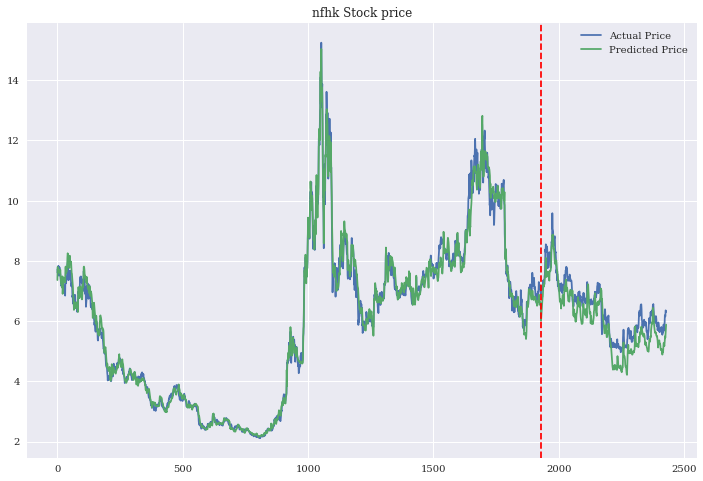

In [50]:
# Handle date/time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(12,8))   # plotting

plt.plot(y.index.values, y['Actual'], label='Actual Price')   # actual plot
plt.plot(y.index.values, y['Predicted'], label='Predicted Price')   # predicted plot
plt.title('nfhk Stock price')
plt.legend() 
plt.axvline(x=y.index.values[1930], c='r', linestyle='--')   # mark the boundary of training and test dataset
plt.show() 

In [51]:
from sklearn.metrics import mean_squared_error
print('RMSE/Mean (Training): {}'.format( \
    mean_squared_error(y.loc[y.index[:training_size], 'Actual'], y.loc[y.index[:training_size], 'Predicted'], \
    squared=False)/y.loc[y.index[:training_size], 'Actual'].mean()))
print('RMSE/Mean (Test): {}'.format( \
    mean_squared_error(y.loc[y.index[training_size:], 'Actual'], y.loc[y.index[training_size:], 'Predicted'], \
    squared=False)/y.loc[y.index[training_size:], 'Actual'].mean()))

RMSE/Mean (Training): 0.04556471178463576
RMSE/Mean (Test): 0.08203325106726517


In [52]:
## Add the label class based on whether stock goes up or down
def add_label_buy(df):
    idx = len(df.columns)
    new_col = np.where(df['Close'] <= df['BB_Lower_Band'].shift(1), 1, 0)  
    df.insert(loc=idx, column='Label_buy', value=new_col)
    df = df.fillna(0)
    
def add_label_sell(df):
    idx = len(df.columns)
    new_col = np.where(df['Close'] >= df['BB_Upper_Band'].shift(1), 1, 0)  
    df.insert(loc=idx, column='Label_sell', value=new_col)
    df = df.fillna(0)

In [53]:
add_label_buy(techindi1) 

In [54]:
add_label_sell(techindi1)
techindi1

,Date,Open,High,Low,Close,Adj Close,Volume,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Label_buy,Label_sell
0,2011-02-23,8.69,8.70,8.45,8.63,7.618300,52687449,0.00,0.000000,52687449,0.000,0.000,0.000,0,0
1,2011-02-24,8.54,8.82,8.40,8.77,7.741889,45998923,0.14,0.000000,45998923,0.000,0.000,0.000,0,1
2,2011-02-25,8.72,8.78,8.50,8.68,7.662439,34295358,-0.09,0.000000,34295358,0.000,0.000,0.000,0,1
3,2011-02-28,8.68,8.82,8.53,8.77,7.741889,51694946,0.09,0.000000,51694946,0.000,0.000,0.000,0,1
4,2011-03-01,8.77,8.99,8.72,8.88,7.838994,59260810,0.11,0.000000,59260810,0.000,0.000,0.000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,2021-02-09,6.18,6.21,6.11,6.20,6.200000,50304320,0.01,65.753425,50304320,5.775,5.947,5.604,0,1
2426,2021-02-10,6.18,6.20,6.10,6.16,6.160000,35436376,-0.04,66.666667,35436376,5.795,5.987,5.604,0,1
2427,2021-02-18,6.25,6.42,6.15,6.36,6.360000,83791920,0.20,69.047619,83791920,5.827,6.056,5.599,0,1
2428,2021-02-19,6.29,6.51,6.28,6.35,6.350000,70460839,-0.01,70.731707,70460839,5.861,6.114,5.608,0,1
